In [123]:
import pandas as pd
import numpy as np
import datetime as datetime
import spacy
import en_core_web_sm
import matplotlib.pyplot as plt
from subprocess import check_output
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import preprocessor as p
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

In [124]:
df = pd.read_csv('trump_tweets_cleaned_2.csv')
print(len(df), 'tweets')

2754 tweets


In [125]:
df.head()

,id,text,favorites,retweets,date,tweet_datetime,date_part,time_part,hour,year,month
0,9.353400e+17,thank rand,42793,9125,2017-11-28 02:50:00,2017-11-28 10:50:00,2017-11-28,10:50:00,10,2017,11
1,8.997980e+17,join live fort myer arlington virginia,36009,4891,2017-08-22 01:00:00,2017-08-22 09:00:00,2017-08-22,09:00:00,9,2017,8
2,8.939700e+17,thank nicole,43367,8275,2017-05-08 23:01:00,2017-05-09 07:01:00,2017-05-09,07:01:00,7,2017,5
3,8.819770e+17,thank shawn steel nice word,50956,7465,2017-03-07 20:44:00,2017-03-08 04:44:00,2017-03-08,04:44:00,4,2017,3
4,8.778460e+17,great night iowa special people thank,56446,8039,2017-06-22 11:11:00,2017-06-22 19:11:00,2017-06-22,19:11:00,19,2017,6


In [126]:
# def twee(text):
#     text1 = p.clean(text)
#     return text1

# tweets_clean = pd.DataFrame(tweets.text.apply(lambda x: twee(x)))

# def remove_hashtag(text):
#     text2 = re.sub(r'#(\w+)', '', text)
#     return text2

# tweets_clean = pd.DataFrame(tweets_clean.text.apply(lambda x: remove_hashtag(x)))
    
# def preprocess_data(data):
#  #Removes Numbers
#     data = data.astype(str).str.replace(r'\d+', '')
#     lower_text = data.str.lower()
#     lemmatizer = nltk.stem.WordNetLemmatizer()
#     w_tokenizer =  TweetTokenizer()
                
#     def lemmatize_text(text):
#         return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]

#     def remove_punctuation(words):
#         new_words = []
#         for word in words:
#             new_word = re.sub(r'[^\w\s]', '', (word))
#             if new_word != '':
#                 new_words.append(new_word)
#         return new_words
    
#     words = lower_text.apply(lemmatize_text)
#     words = words.apply(remove_punctuation)
#     return pd.DataFrame(words)

# tweets_clean['text'] = preprocess_data(tweets_clean['text'])

# stop_words = set(set(stopwords.words('english')).union({'amp'}))
# tweets_clean['text'] = tweets_clean['text'].apply(lambda x: [item for item in x if item not in stop_words])
# tweets_clean['text'] = tweets_clean['text'].apply(lambda x: " ".join(x))

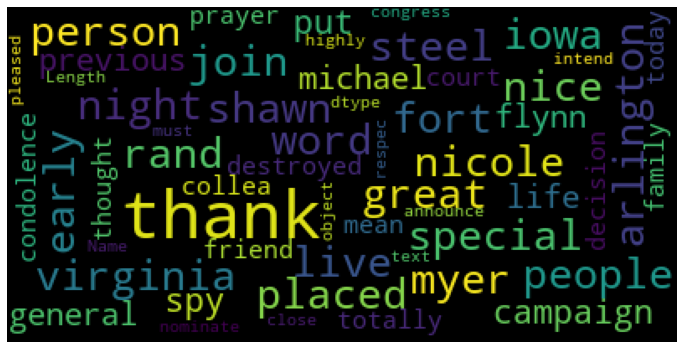

In [127]:
plt.rcParams['figure.figsize'] = (12.0,12.0)  
plt.rcParams['font.size'] = 12            
plt.rcParams['savefig.dpi'] = 100             
plt.rcParams['figure.subplot.bottom'] = .1 
wordcloud = WordCloud(background_color='black',
                      stopwords=stop_words,
                      max_words=500,
                      max_font_size=40, 
                      random_state=100
                      ).generate(str(df.text))
print(wordcloud)
#fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [129]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_words(df.text.values.astype('U'), 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [130]:
print(unigram)

    unigram  count
0     great    748
1        wa    417
2    people    324
3        ha    317
4   country    296
5       job    246
6     thank    235
7       big    223
8   america    215
9  democrat    215


In [131]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_trigram(df.text.values.astype('U'), 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [132]:
print(trigram)

                   trigram  count
0         fake news medium     59
1       make america great     50
2           wa great honor     48
3     making america great     24
4              kim jong un     19
5        love military vet     19
6           tax cut reform     18
7      great honor welcome     17
8        rigged witch hunt     17
9  crooked hillary clinton     15


<AxesSubplot:>

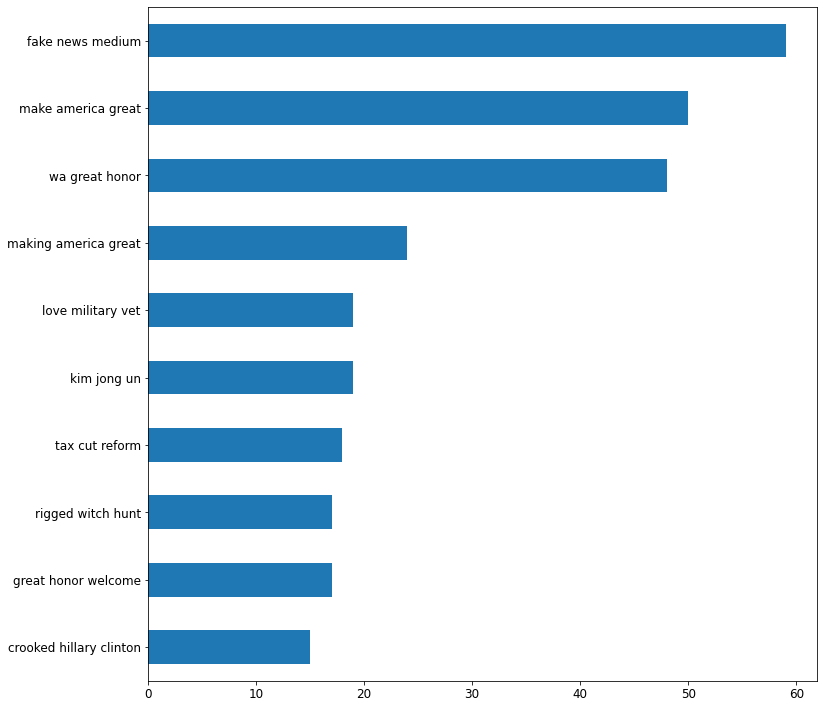

In [133]:
plotdata = pd.DataFrame({"count": list(trigram['count'])}, 
                          index = list(trigram['trigram'])).sort_values('count', ascending = True)
plotdata['count'].plot(kind="barh")

In [134]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,# minimum required occurences of a word 
                             stop_words='english',# remove stop words
                             lowercase=True,# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
                             max_features=5000,# max number of unique words
                            )

data_matrix = vectorizer.fit_transform(df.text.values.astype('U'))
data_matrix

<2754x2083 sparse matrix of type '<class 'numpy.int64'>'
	with 30715 stored elements in Compressed Sparse Row format>

In [135]:
lda_model = LatentDirichletAllocation(n_components=10, 
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1)

lda_output = lda_model.fit_transform(data_matrix)

In [136]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  14.440803
3       0.648955  71.707100       2        1  12.086026
2      71.019684   9.971006       3        1  11.841888
1       3.785981  33.185135       4        1  11.260976
5     -42.666500  -9.222070       5        1  11.247294
8      -3.621689 -43.526516       6        1   9.848251
9      -3.632402  -4.171708       7        1   9.062097
7     -36.584400  35.804413       8        1   8.107068
6      44.391380  50.615383       9        1   7.259944
4      40.235809 -31.591665      10        1   4.845654, topic_info=            Term        Freq       Total Category  logprob  loglift
1240        news  196.000000  196.000000  Default  30.0000  30.0000
1926       trump  202.000000  202.000000  Default  29.0000  29.0000
185       border  197.000000  197.000000  Default  28.0000  28.0000
1840         tax  164.000000  164.000000  Default  27.0000  27.0000
639         fake  170.000000  170.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1204       month   12.690220   32.291305  Topic10  -4.8194   2.0931
1913  tremendous   12.674326   33.239064  Topic10  -4.8207   2.0629
435          day   16.257417   99.111748  Topic10  -4.5717   1.2194
724       friend   12.967471   42.838505  Topic10  -4.7978   1.8321
1745    spending   11.170827   22.467368  Topic10  -4.9470   2.3283

[556 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0        10  0.869628             abc
12        4  0.953058       according
24        3  0.974397        actually
31        1  0.086428  administration
31        2  0.432142  administration
...     ...       ...             ...
2074      5  0.135353            year
2074      6  0.026029            year
2074      7  0.062471            year
2074      8  0.307147            year
2074      9  0.119735            year

[776 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 6, 9, 10, 8, 7, 5])

In [118]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['day', 'world', 'honor', 'state', 'today', 'president', 'korea', 'north', 'meeting', 'great']


Top 10 words for topic #1:
['united', 'senator', 'senate', 'congress', 'need', 'people', 'state', 'republican', 'vote', 'democrat']


Top 10 words for topic #2:
['people', 'country', 'making', 'new', 'time', 'look', 'american', 'make', 'great', 'america']


Top 10 words for topic #3:
['crooked', 'russian', 'comey', 'clinton', 'trump', 'story', 'hillary', 'collusion', 'campaign', 'fbi']


Top 10 words for topic #4:
['union', 'donald', 'despite', 'member', 'thought', 'thank', 'dollar', 'billion', 'president', 'trump']


Top 10 words for topic #5:
['court', 'wall', 'strong', 'want', 'great', 'country', 'military', 'crime', 'job', 'border']


Top 10 words for topic #6:
['people', 'love', 'service', 'national', 'happy', 'south', 'truly', 'nan', 'really', 'thank']


Top 10 words for topic #7:
['tariff', 'better', 'year', 'job', 'big', 'economy', 'deal', 'trade', 'cut', 

In [121]:
topic_values = lda_model.transform(data_matrix)
df['Topic'] = topic_values.argmax(axis=1)

In [122]:
df

,id,text,favorites,retweets,date,tweet_datetime,date_part,time_part,hour,year,month,Topic
0,9.353400e+17,thank rand,42793,9125,2017-11-28 02:50:00,2017-11-28 10:50:00,2017-11-28,10:50:00,10,2017,11,1
1,8.997980e+17,join live fort myer arlington virginia,36009,4891,2017-08-22 01:00:00,2017-08-22 09:00:00,2017-08-22,09:00:00,9,2017,8,2
2,8.939700e+17,thank nicole,43367,8275,2017-05-08 23:01:00,2017-05-09 07:01:00,2017-05-09,07:01:00,7,2017,5,6
3,8.819770e+17,thank shawn steel nice word,50956,7465,2017-03-07 20:44:00,2017-03-08 04:44:00,2017-03-08,04:44:00,4,2017,3,3
4,8.778460e+17,great night iowa special people thank,56446,8039,2017-06-22 11:11:00,2017-06-22 19:11:00,2017-06-22,19:11:00,19,2017,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2749,9.990960e+17,person placed early campaign spy put previous ...,78529,20098,2018-05-23 01:13:00,2018-05-23 09:13:00,2018-05-23,09:13:00,9,2018,5,3
2750,9.874600e+17,general michael flynn life totally destroyed s...,93569,25259,2018-04-20 10:34:00,2018-04-20 18:34:00,2018-04-20,18:34:00,18,2018,4,3
2751,9.870960e+17,thought prayer condolence family friend collea...,62645,16081,2018-04-19 22:30:00,2018-04-20 06:30:00,2018-04-20,06:30:00,6,2018,4,2
2752,9.863570e+17,today court decision mean congress must close ...,56749,12426,2018-04-17 21:34:00,2018-04-18 05:34:00,2018-04-18,05:34:00,5,2018,4,2


In [137]:
df.to_csv("topic_modelling_output.csv", index=False, header=True)